In [1]:
import math
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [6]:
""" data analysis with chi-square goodness of fit"""

def obs_cts(n, data):
    """ given: the data and number of bins
        returns: the observed values and the bin edges as lists"""
    events, edges = np.histogram(data, n)
    return events.tolist() , edges.tolist()

def exp_cts(n, data):
    """ given: the data and number of bins
        returns: the expected values and prob over each of the bins with
        the necessary modification of the first and last bins"""
    L=[]
    P_bins =[]
    for x in obs_cts(n,data)[1]:
        L.append(rv.cdf(x))
    P_bins.append(L[1])    
    for i in range(1,len(L)-2):
        P_bins.append(L[i+1]-L[i])    
    P_bins.append(1-L[-2])
    exp_cnt = [x * len(data) for x in P_bins]
    return exp_cnt, P_bins

def ind_bins_to_reduce(f_exp):
    """ given: a list
        returns: the indexes of the elements < 5"""
    NC_to_red =[index for index,value in enumerate(f_exp) if value < 5]
    return NC_to_red

def one_reduce(f_exp, f_obs, f_edge):
    """ given: lists of exp, obs, edges
        returns: new lists with one reduced bin with value < 5 """
    BTR = ind_bins_to_reduce(f_exp)
  
    if (len(BTR)>1 or (len(BTR)==1 and BTR[0]!=0)):
        f_exp[BTR[-1]-1] = f_exp[BTR[-1]-1]+f_exp[BTR[-1]]
        f_obs[BTR[-1]-1] = f_obs[BTR[-1]-1]+f_obs[BTR[-1]]
        del(f_edge[BTR[-1]])
        del(f_obs[BTR[-1]])
        del(f_exp[BTR[-1]])
    else:
        if BTR[0]==0:
            f_exp[1]= f_exp[1]+f_exp[0]
            f_obs[1]= f_obs[1]+f_obs[0]
            del(f_edge[1])
            del(f_obs[0])
            del(f_exp[0])

    f_expN = f_exp
    f_obsN = f_obs
    f_edgeN = f_edge
    BTRN = ind_bins_to_reduce(f_expN)
    return f_expN, f_obsN, f_edgeN, BTRN

def all_reduce(f_expF, f_obsF, f_edgeF, BTRF):
    """ finalizes the bin reduction """
    while BTRF !=[]:
        u = one_reduce(f_expF, f_obsF, f_edgeF)
        f_expF = u[0]
        f_obsF = u[1]
        f_edgeF = u[2]
        BTRF = u[3]
    return f_expF, f_obsF, f_edgeF, BTRF


def model(data, n, dof):
        """ given data, the number of bins (n) and the number of estimated parameters (dof)
        produces the value of the chi-squate test statistics and the p-value"""

        ## final expected count and final observed count after amalgamating bins
        exp, obs = all_reduce(exp_cts(n, data)[0],obs_cts(n, data)[0],
                obs_cts(n, data)[1], ind_bins_to_reduce(exp_cts(n, data)[0]))[0:2] 
        # build in chi-gof test, the last argument is the adjustment to the dof
        result = ss.chisquare( np.asarray(obs), np.asarray(exp), dof) 
        return result 

In [7]:
def skipHeader(dataFile):
    dataFile.readline()
    dataFile.readline()
    dataFile.readline()
    dataFile.readline()
    
def readData(periods):
    for i in range(1,11):
        f = open('./Data/results' + str(i) + '.txt', 'r')
        skipHeader(f) #Skips the four header lines at the time of the file.

        arrivals = [] # Array of arrivals for a period of time
        departures = [] # Array of departures for a period of time
        startTime = float(f.readline()[0:-1].split('  ')[0])
        endTime = None

        for line in f:
            observation = line[0:-1].split('  ')
            if observation[1] == 'a':
                arrivals.append(float(observation[0]))
            elif observation[1] == 'd':
                departures.append(float(observation[0]))
            else:
                endTime = float(observation[0])

        periods.append([startTime, arrivals, departures, endTime])

In [8]:
periods = [] # Array containing periods of format [start time, arrivals, departures, end time]
readData(periods)

interArrivalTimes = []
for p in periods:
    for a in range(1, len(p[1])):
        interArrivalTimes.append(p[1][a] - p[1][a - 1])        
interArrivalBins = int(round(1 + np.log2(len(interArrivalTimes))))

serviceTimes = []
for p in periods:
    for i in range(1, len(p[1])):
        serviceTimes.append(p[2][i] - p[1][i])
serviceBins = int(round(1 + np.log2(len(serviceTimes))))

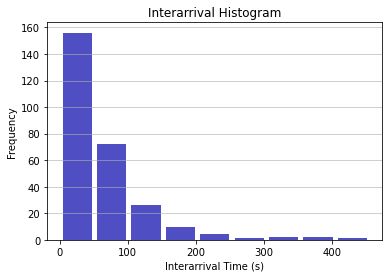

In [9]:
#Interarrival Histogram
plt.hist(x=interArrivalTimes, bins=interArrivalBins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Interarrival Time (s)')
plt.ylabel('Frequency')
plt.title('Interarrival Histogram')
plt.plot();

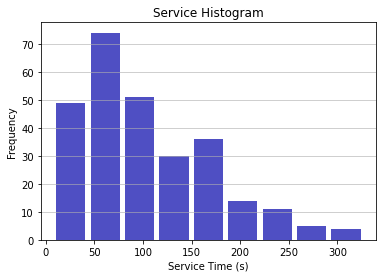

In [10]:
#Service Histogram
plt.hist(x=serviceTimes, bins=serviceBins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Service Time (s)')
plt.ylabel('Frequency')
plt.title('Service Histogram')
plt.plot();

In [7]:
#Goodness of fit for interarrival data with exponential distribution

#parameter estimation 
params=ss.expon.fit(interArrivalTimes, floc=0)
rv = ss.expon(params[0],params[1])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 1

# chose the number of bins
n=int(round(1 + np.log2(len(interArrivalTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(interArrivalTimes, n, dof)[0], model(interArrivalTimes,n,dof)[1]))

The chi_sq test value is   1.198479 and the p-value is   0.753369


C:\Users\James\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


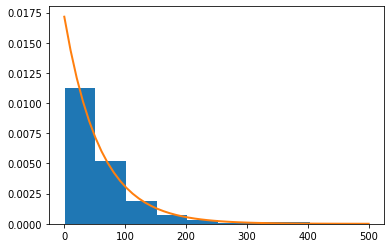

In [8]:
myHist = plt.hist(interArrivalTimes, int(round(1 + np.log2(len(interArrivalTimes)))), normed=True)
x = np.linspace(0.001,500) 
h = plt.plot(x, rv.pdf(x), lw=2)

In [9]:
#Goodness of fit for interarrival data with gamma distribution

#parameter estimation 
params=ss.gamma.fit(interArrivalTimes, floc=0)
rv = ss.gamma(params[0],params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(interArrivalTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(interArrivalTimes, n, dof)[0], model(interArrivalTimes,n,dof)[1]))

The chi_sq test value is   5.599012 and the p-value is   0.132835


In [10]:
#Goodness of fit for interarrival data with erlang distribution

#parameter estimation 
params=ss.erlang.fit(interArrivalTimes, floc=0)

rv = ss.erlang(round(params[0]),params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(interArrivalTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(interArrivalTimes, n, dof)[0], model(interArrivalTimes,n,dof)[1]))

The chi_sq test value is  16.188230 and the p-value is   0.001038


In [11]:
#Goodness of fit for service data with exponential distribution

#parameter estimation 
params=ss.expon.fit(serviceTimes, floc=0)
rv = ss.expon(params[0],params[1])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 1

# chose the number of bins
n=int(round(1 + np.log2(len(serviceTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(serviceTimes, n, dof)[0], model(serviceTimes,n,dof)[1]))

The chi_sq test value is  62.223869 and the p-value is   0.000000


In [12]:
#Goodness of fit for service data with gamma distribution

#parameter estimation 
params=ss.gamma.fit(serviceTimes, floc=0)
rv = ss.gamma(params[0],params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(serviceTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(serviceTimes, n, dof)[0], model(serviceTimes,n,dof)[1]))

The chi_sq test value is  11.278737 and the p-value is   0.046125


C:\Users\James\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


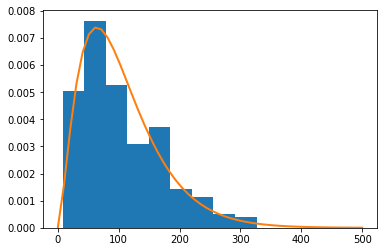

In [13]:
myHist = plt.hist(serviceTimes, int(round(1 + np.log2(len(serviceTimes)))), normed=True)
x = np.linspace(0.001,500) 
h = plt.plot(x, rv.pdf(x), lw=2)

In [14]:
#Goodness of fit for service data with erlang distribution

#parameter estimation 
params=ss.erlang.fit(serviceTimes, floc=0)

rv = ss.erlang(round(params[0]),params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(serviceTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(serviceTimes, n, dof)[0], model(serviceTimes,n,dof)[1]))

The chi_sq test value is  42.146190 and the p-value is   0.000000
